In [6]:
%config InlineBackend.figure_format = 'retina'


In [7]:
import numpy as np
import pandas as pd

from datetime import datetime

from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


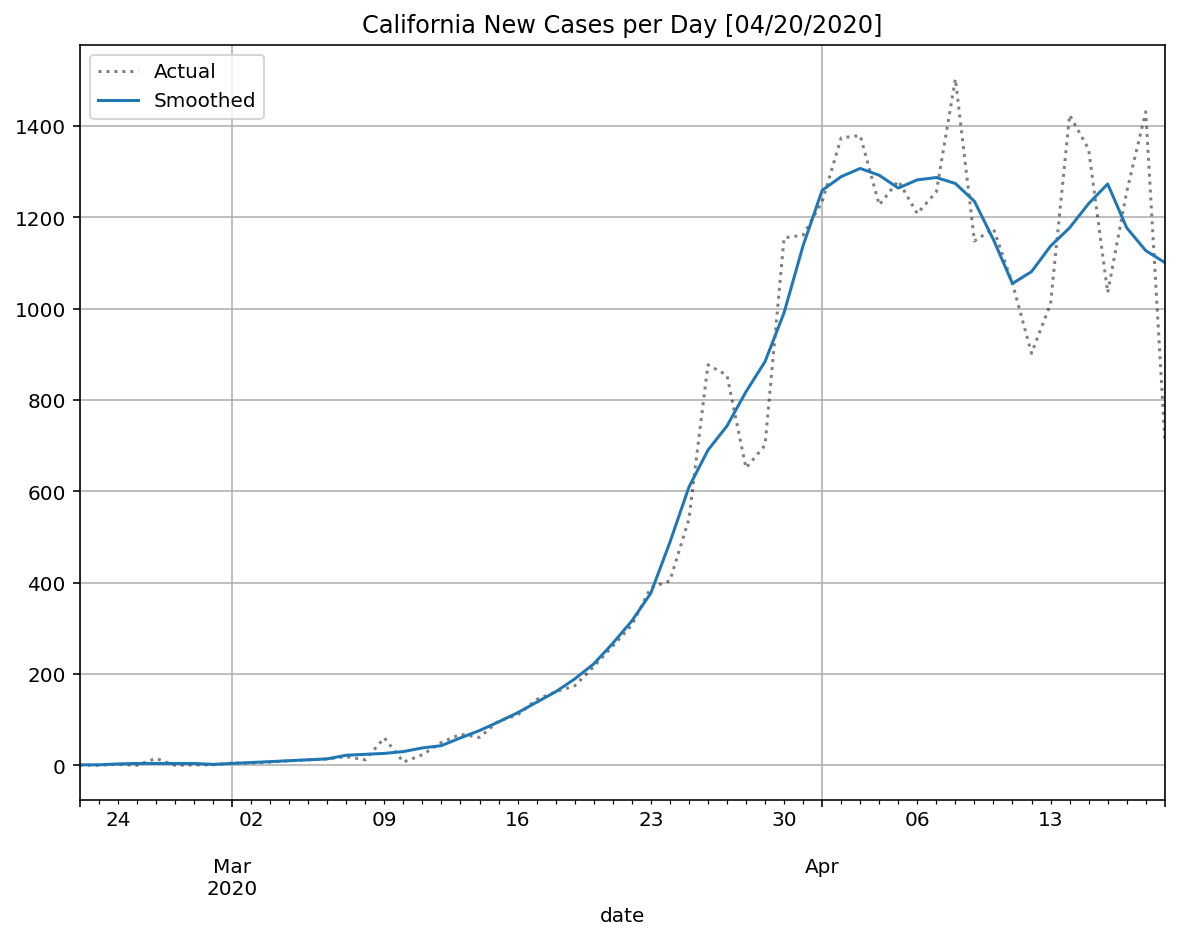

In [8]:
state_name = 'California'

url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,
                     usecols=[0,1,3],
                     index_col=['state', 'date'],
                     parse_dates=['date']).sort_index()

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(5,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name)\
    .squeeze()\
    .rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f'{state_name} New Cases per Day [{datetime.now().strftime("%m/%d/%Y")}]',
               c='k',
               linestyle=':',
               alpha=.5,
               grid=True,
               label='Actual',
               legend=True,
               figsize=(700/72, 500/72))

ax = smoothed.plot(label='Smoothed', legend=True, grid=True)
ax.get_figure().set_facecolor('w')


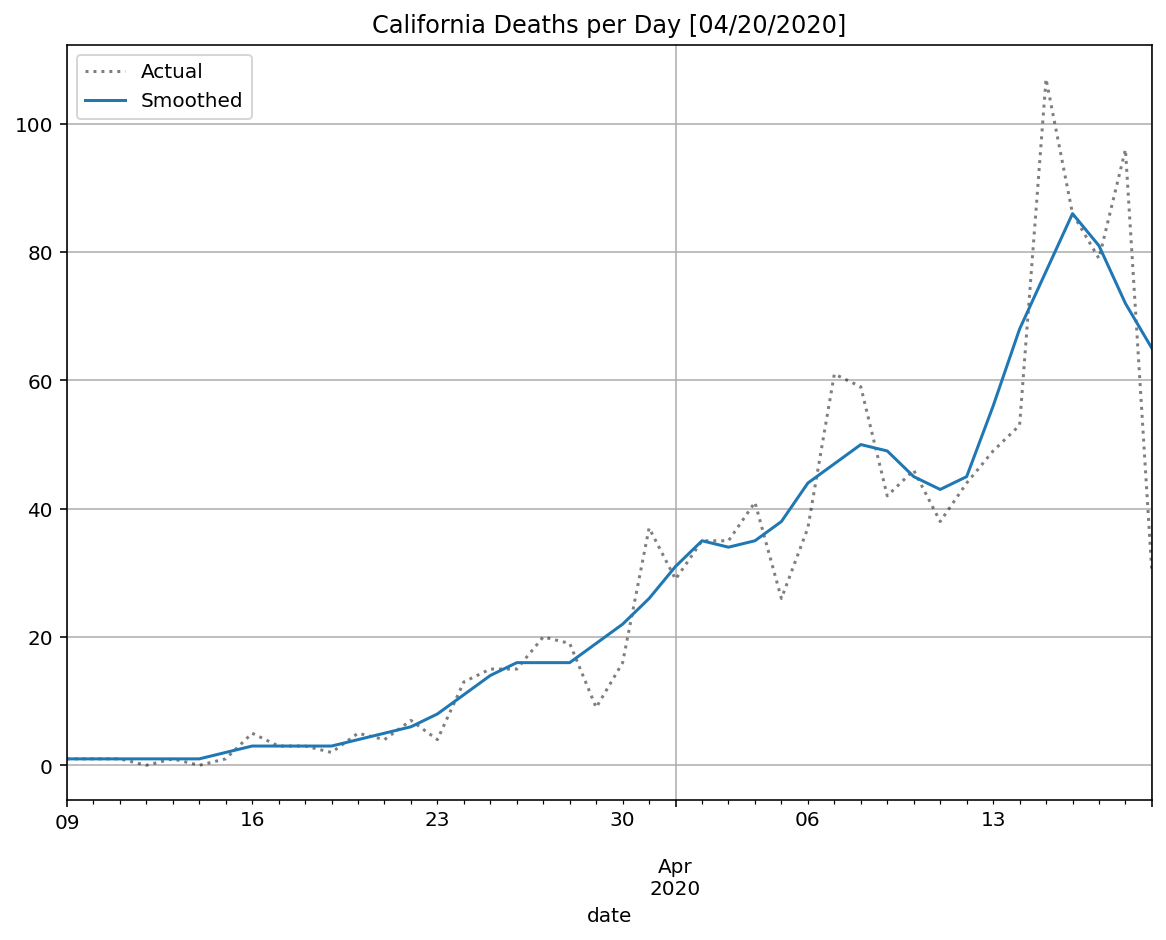

In [9]:
state_name = 'California'

url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,
                     usecols=[0,1,4],
                     index_col=['state', 'date'],
                     parse_dates=['date']).sort_index()

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(5,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name)\
    .squeeze()\
    .rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f'{state_name} Deaths per Day [{datetime.now().strftime("%m/%d/%Y")}]',
               c='k',
               linestyle=':',
               alpha=.5,
               grid=True,
               label='Actual',
               legend=True,
               figsize=(700/72, 500/72))

ax = smoothed.plot(label='Smoothed', legend=True, grid=True)
ax.get_figure().set_facecolor('w')

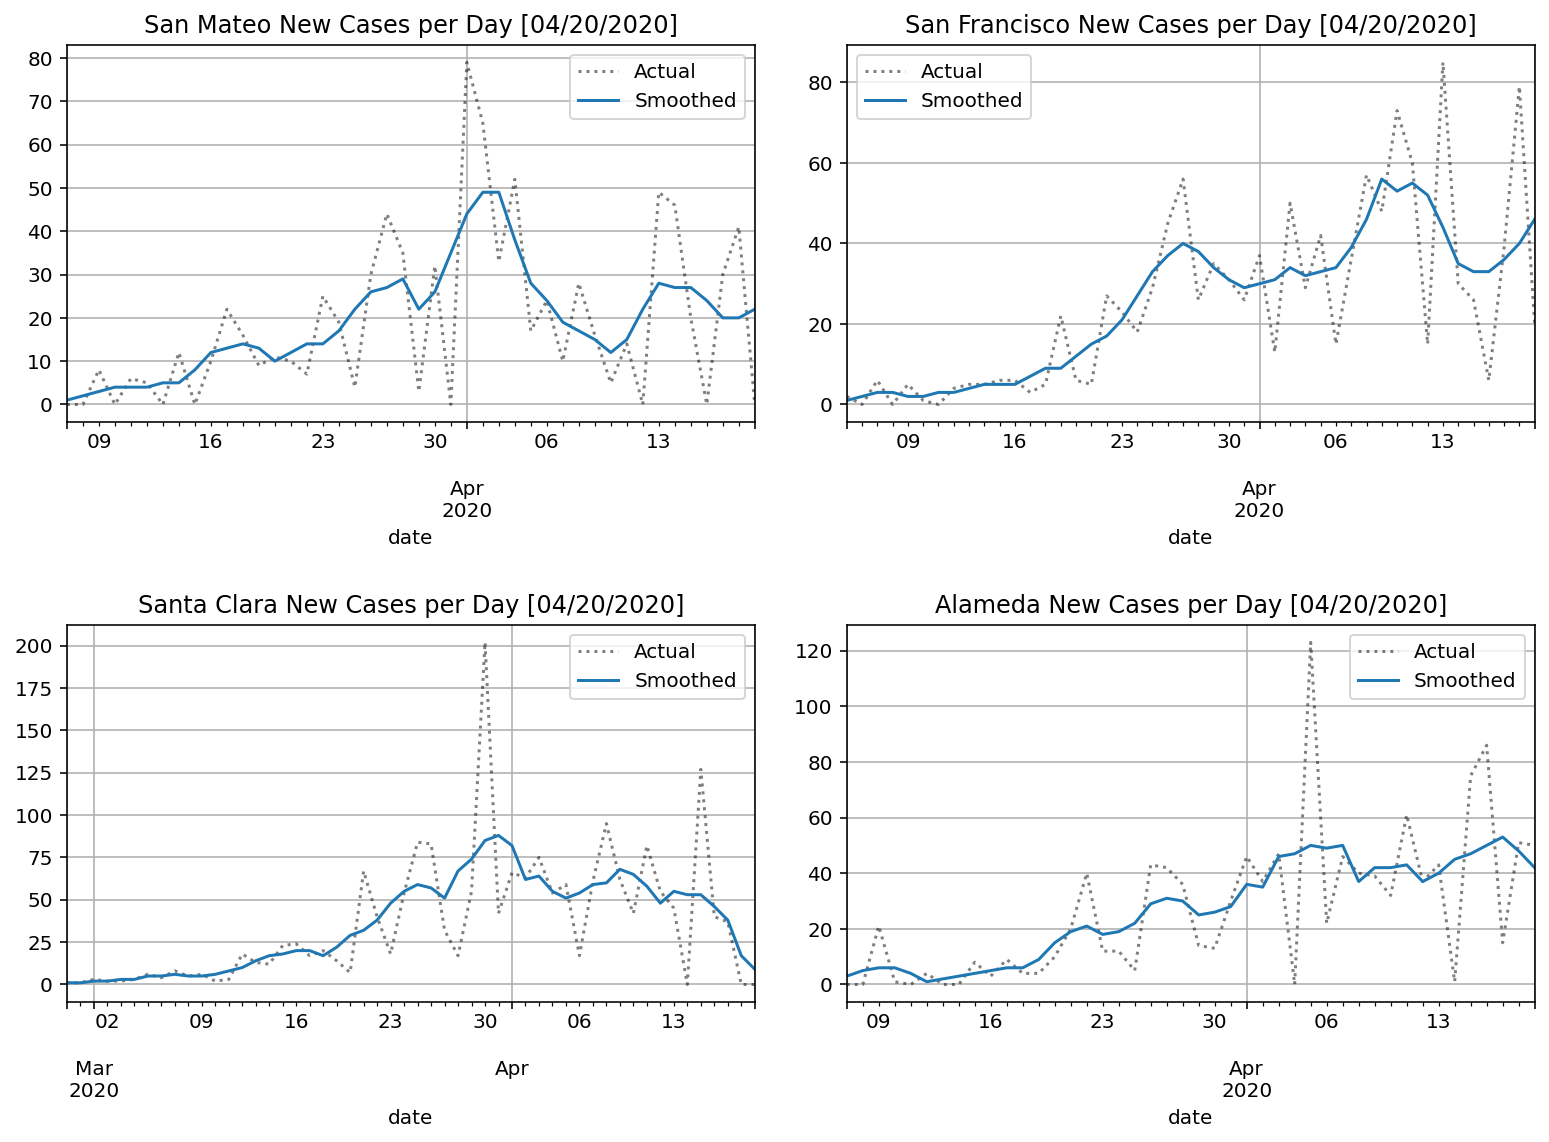

In [10]:
# new cases in 4 counties broken out

url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

counties = pd.read_csv(url,
              parse_dates=['date'],
              squeeze=True)

interested_counties = [
        'San Mateo', 
        'San Francisco',
        'Santa Clara',
        'Alameda'
]

counties = counties[counties.county.isin(interested_counties)]\
        .drop(columns=['state', 'fips', 'deaths'])\
        .set_index(['county', 'date'])\
        .sort_index()

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(5,
        win_type='gaussian',
        min_periods=0,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

fig, axs = plt.subplots(2, 2)

for i, county_name in enumerate(interested_counties):
    coords = [int(x) for x in list(f"{i:02b}")]
    ax = axs[coords[0], coords[1]]
    
    cases = counties.xs(county_name)\
        .squeeze()\
        .rename(f"{county_name} cases")

    original, smoothed = prepare_cases(cases)

    original.plot(title=f'{county_name} New Cases per Day [{datetime.now().strftime("%m/%d/%Y")}]',
                  c='k',
                  linestyle=':',
                  alpha=.5,
                  label='Actual',
                  legend=True,
                  grid=True,
                  figsize=(800/72, 600/72),
                  ax=ax)

    smoothed.plot(label='Smoothed', legend=True, grid=True, ax=ax)
    fig.set_facecolor('w')
    fig.tight_layout(pad=2.0)
